# PS reconstruction, non-Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
data_dir = 'data'
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(
    base_yaml = os.path.join(data_dir, 'yaml_files', 'base.yaml'),
    transforms_yaml = os.path.join(data_dir, 'yaml_files', 'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 1_000_000,
    save_as = os.path.join('data', 'non_gaussian_beam.pt')
)

ground truth distribution saved at data/non_gaussian_beam.pt


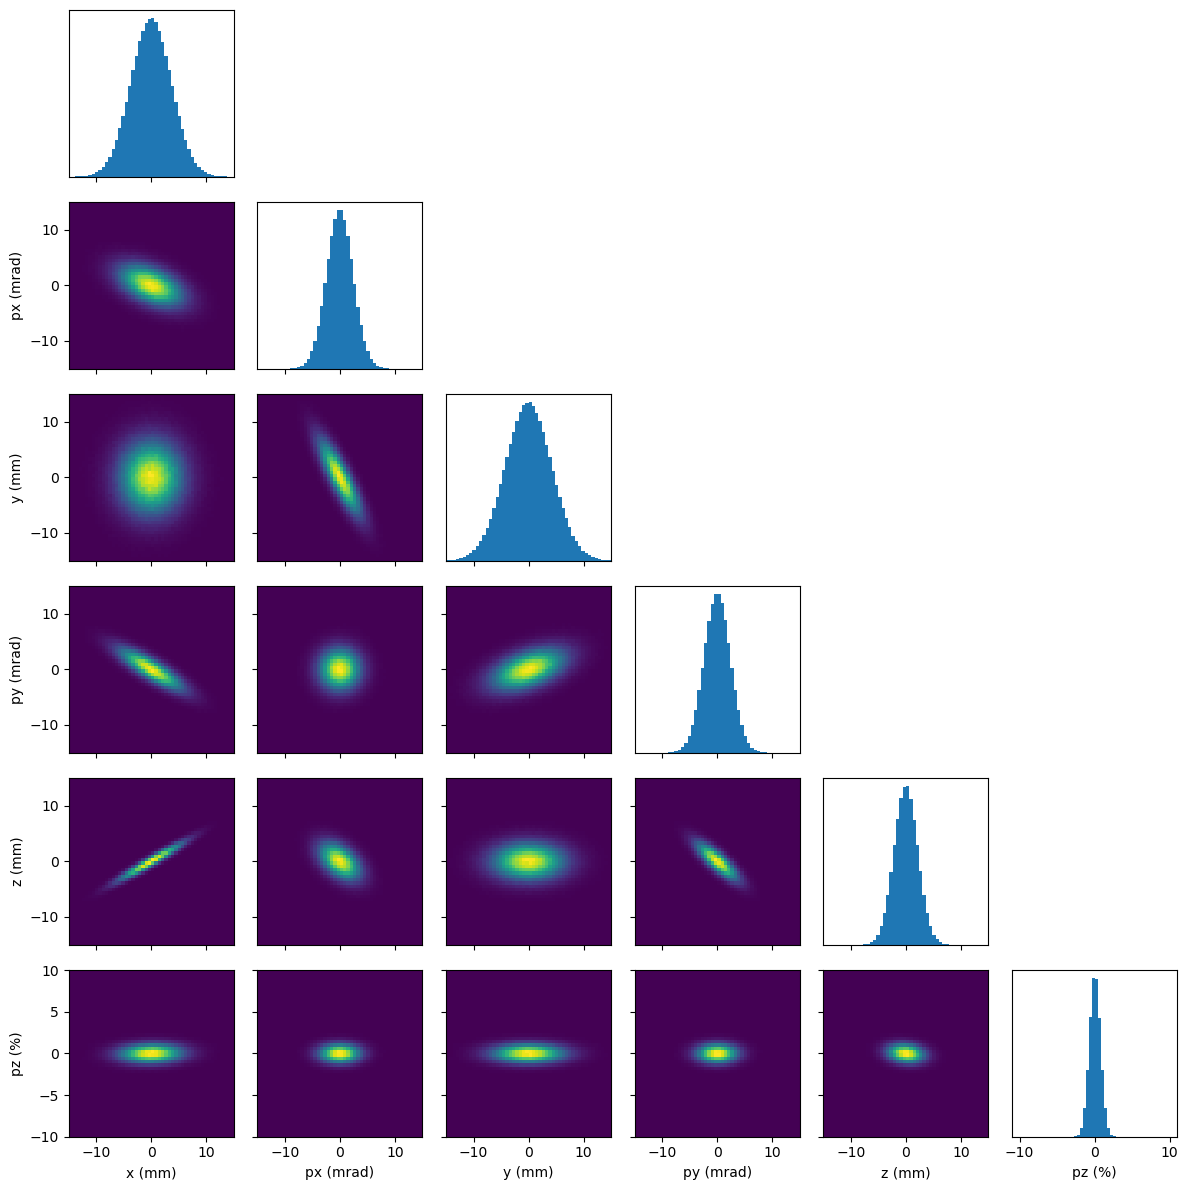

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-2, 5e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 5.364958
k2 = -20.0
k3 = 12.662418

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(data_dir, 't_scan', '3d_scan_train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/t_scan/3d_scan_train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


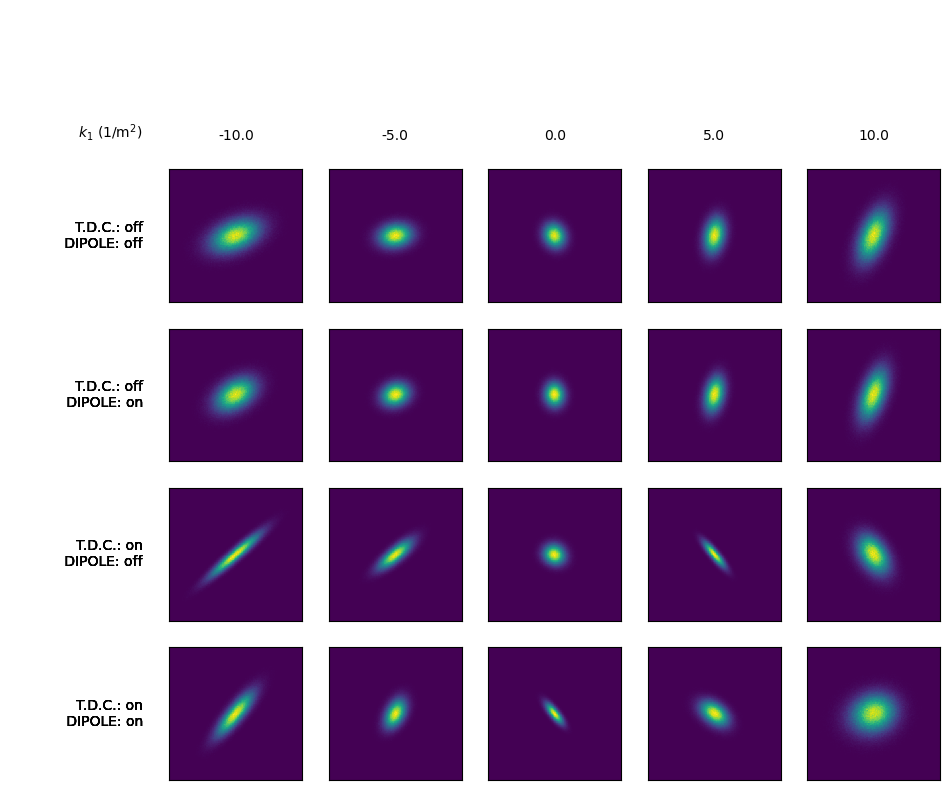

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

### 100,000 particles

In [8]:
%%time

# training with 4 gpus
pred_beam_3d_scan_100_000 = train_3d_scan(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 2_000, 
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(3503936., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(319184.2500, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(275564.8438, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(284735.2812, device='cuda:0', grad_fn=<MulBackward0>)



KeyboardInterrupt



In [ ]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_3d_scan_100_000.numpy_particles(),
    custom_lims = lims
)
plt.show()

In [ ]:
torch.save(pred_beam_3d_scan_100_000, os.path.join(data_dir, 'gaussian', '3D_scan_100_000.pt'))

In [ ]:
torch.cuda.empty_cache()

## 'T' scan training data

In [ ]:
# generate and save train and test datasets
train_dset_t_scan = run_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join(data_dir, 't_scan', 't_scan_train.dset')
    )

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

In [ ]:
%%time

# training
pred_beam_t_scan_100_000 = train_3d_scan(
    train_dset_t_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 2_000, 
    n_particles = 100_000, 
    device = 'cuda:0'
    )

In [ ]:
# reconstructed beam projections:
fig, ax = plot_projections(
    pred_beam_t_scan_100_000.numpy_particles(),
    custom_lims = lims
)
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.save(pred_beam_t_scan_100_000, os.path.join(data_dir, 'gaussian', 't_scan_100_000.pt'))